In [1]:
import pandas as pd
from constants import base_path
import matplotlib.pyplot as plt
import numpy as np
import json
import ast
from collections import Counter

In [2]:
diagnosis_df_valid = pd.read_csv(f"{base_path}\\input\\release_validate_patients")

In [3]:
with open(f"{base_path}\\input\\release_evidences.json") as f:
  evidences = json.load(f)
evidences_list = []
evidences_dict = {}
evidences_en_to_code = {}
for e in evidences.keys():
  # only binary symptoms and no antecedents
  if (not evidences[e]["possible-values"]) and (not evidences[e]["is_antecedent"]):
    evidences_list.append(e)
    evidences_dict[e] = evidences[e]["question_en"]
    evidences_en_to_code[evidences[e]["question_en"]] = e
evidences_code_to_en = evidences_dict
evidences_list_en = list(evidences_en_to_code.keys())

In [4]:
with open(f"{base_path}\\input\\release_conditions.json") as f:
  disease_dict = json.load(f)
disease_list = list(disease_dict.keys())

In [5]:
def get_misses(degraded_df, feature_importance_dict):
    missed_evidences_per_disease = {}
    for disease in disease_list:
        disease_df = degraded_df[degraded_df["PATHOLOGY"]==disease]

        # here, we want to count the most missed evidence per disease
        missed_evidences = []
        for e in disease_df["missed_evidence"]:
            e = ast.literal_eval(e)
            if e:
                missed_evidences.extend(e)
        missed_evidences_dict = dict(Counter(missed_evidences).most_common(10))
        missed_evidences_dict = {evidences_code_to_en[k]:missed_evidences_dict[k] for k in missed_evidences_dict}

        # hypothesis: the initial evidence is not very specific, hence the degrade in predictions
        initial_evidences_dict = dict(Counter(list(disease_df["INITIAL_EVIDENCE"])).most_common(10))
        initial_evidences_dict = {
            evidences_code_to_en[k]:{
                "is_relevant": evidences_code_to_en[k] in feature_importance_dict[disease]["top10_relevant_symptoms"],
                "count": initial_evidences_dict[k]
                } 
                for k in initial_evidences_dict}
        missed_evidences_per_disease[disease] = {
            "top_missed_evidences": missed_evidences_dict,
            "initial_evidences_count": initial_evidences_dict
        }
    return missed_evidences_per_disease

## Random Forest

In [6]:
with open(f"{base_path}\\output\\feature_importance.json") as f:
  feature_importance_dict = json.load(f)
# feature_importance_dict

In [7]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [8]:
valid_df_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\questionnaire_df.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [9]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [10]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,0.857143
1,['Panic attack'],True,1.000000
2,['Influenza'],True,1.000000
3,['Myocarditis'],False,0.333333
4,['Possible NSTEMI / STEMI'],False,0.666667
...,...,...,...
132443,['Acute otitis media'],False,1.000000
132444,['Acute pulmonary edema'],True,1.000000
132445,['GERD'],True,1.000000
132446,['Epiglottitis'],True,1.000000


In [11]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,0.857143
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.000000
2,Influenza,['Influenza'],True,['Influenza'],True,1.000000
3,Anemia,['Anemia'],True,['Myocarditis'],False,0.333333
4,Boerhaave,['Boerhaave'],True,['Possible NSTEMI / STEMI'],False,0.666667
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Acute otitis media'],False,['Acute otitis media'],False,1.000000
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.000000
132445,GERD,['GERD'],True,['GERD'],True,1.000000
132446,Epiglottitis,['Epiglottitis'],True,['Epiglottitis'],True,1.000000


In [12]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 22914 degraded predictions. previously correctly diagnosed but misdiagnosed using the questionnaire
# 178 corrected predictions. prerviously misdiagnosed but correctly diagnosed using the questionnaire

is_matched_questionnaire,False,True
is_matched,,
False,12418,178
True,22914,96938


In [13]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [14]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.4741917249150818

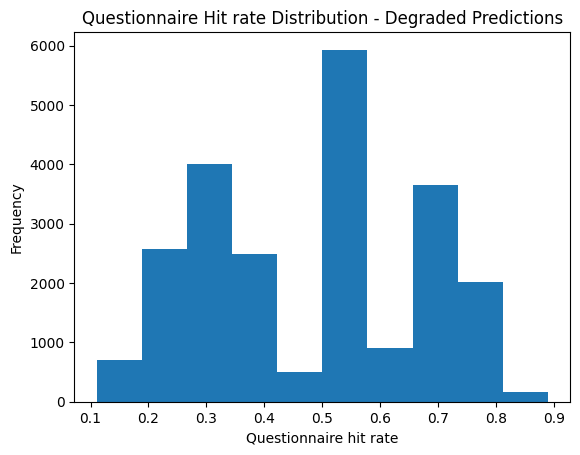

In [15]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded.jpg', bbox_inches='tight')

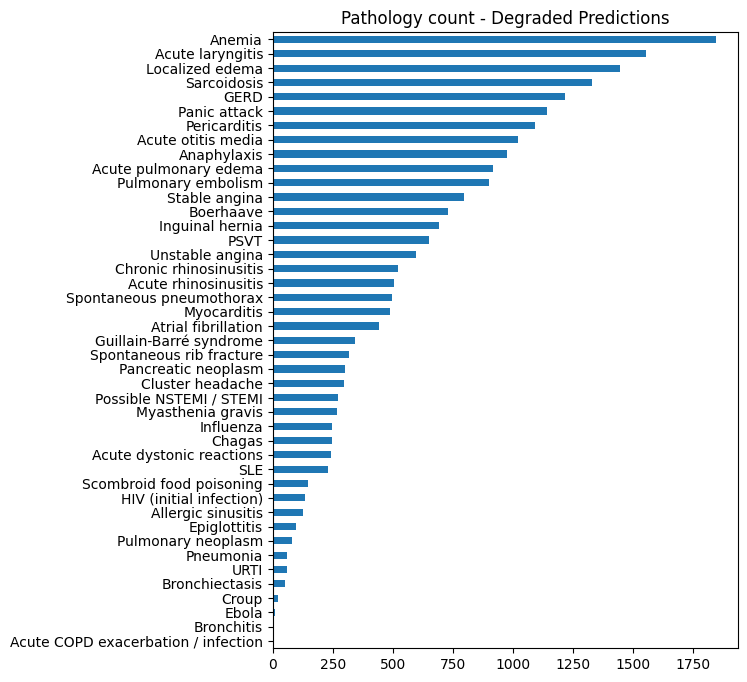

In [16]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded.jpg', bbox_inches='tight')

In [17]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_140', 'E_82', 'E_76', 'E_88', 'E_...",E_154,['E_53']
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_75', 'E_111', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_181', 'E_91', 'E_50', 'E_129', 'E_...",E_53,[]
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66']",E_53,"['E_76', 'E_82', 'E_89', 'E_179']"
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_53', 'E_181']",E_201,[]
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_66', 'E_53', 'E_217']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_53', 'E_194', 'E_190', 'E_65']",E_91,[]


In [18]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
3,Anemia,['Anemia'],True,['Myocarditis'],False,0.333333,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66']",E_53,"['E_76', 'E_82', 'E_89', 'E_179']"
4,Boerhaave,['Boerhaave'],True,['Possible NSTEMI / STEMI'],False,0.666667,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148']",E_53,['E_210']
7,Acute otitis media,['Acute otitis media'],True,['GERD'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
8,Pulmonary embolism,['Pulmonary embolism'],True,"['Myocarditis', 'Stable angina', 'Pericarditis']",False,0.500000,"['E_53', 'E_66', 'E_159', 'E_220']","['E_53', 'E_66']",E_53,"['E_159', 'E_220']"
25,Panic attack,['Panic attack'],True,['Possible NSTEMI / STEMI'],False,0.428571,"['E_50', 'E_53', 'E_111', 'E_148', 'E_157', 'E...","['E_148', 'E_50', 'E_53']",E_148,"['E_171', 'E_177', 'E_157', 'E_111']"
...,...,...,...,...,...,...,...,...,...,...
132396,Acute rhinosinusitis,['Acute rhinosinusitis'],True,['Acute otitis media'],False,0.750000,"['E_53', 'E_91', 'E_182', 'E_201']","['E_201', 'E_53', 'E_91']",E_201,['E_182']
132404,GERD,['GERD'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_201', 'E_215']","['E_53', 'E_201']",E_53,['E_215']
132405,PSVT,['PSVT'],True,"['Stable angina', 'Possible NSTEMI / STEMI']",False,0.500000,"['E_53', 'E_66', 'E_76', 'E_155']","['E_66', 'E_53']",E_66,"['E_155', 'E_76']"
132409,Acute rhinosinusitis,['Acute rhinosinusitis'],True,['Viral pharyngitis'],False,0.600000,"['E_53', 'E_91', 'E_103', 'E_182', 'E_201']","['E_53', 'E_201', 'E_91']",E_53,"['E_103', 'E_182']"


In [19]:
missed_evidences_per_disease = get_misses(degraded_df, feature_importance_dict)

In [20]:
missed_evidences_per_disease["Anemia"] # top 1 degrade

{'top_missed_evidences': {'Do you feel lightheaded and dizzy or do you feel like you are about to faint?': 1147,
  'Do you feel so tired that you are unable to do your usual activities or are you stuck in your bed all day long?': 1116,
  'Do you constantly feel fatigued or do you have non-restful sleep?': 1051,
  'Do you feel slightly dizzy or lightheaded?': 1047,
  'Is your skin much paler than usual?': 1046,
  'Have you noticed light red blood or blood clots in your stool?': 1035,
  'Have you recently had stools that were black (like coal)?': 1014,
  'Do you have very abundant or very long menstruation periods?': 345,
  'Do you have pain somewhere, related to your reason for consulting?': 13,
  'Are you experiencing shortness of breath or difficulty breathing in a significant way?': 9},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': {'is_relevant': True,
   'count': 1153},
  'Are you experiencing shortness of breath or difficulty br

In [21]:
missed_evidences_per_disease["Acute laryngitis"] # top 2 degrade

{'top_missed_evidences': {'Have you noticed that the tone of your voice has become deeper, softer or hoarse?': 1556},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': {'is_relevant': True,
   'count': 889},
  'Do you have a cough?': {'is_relevant': True, 'count': 366},
  'Do you have a fever (either felt or measured with a thermometer)?': {'is_relevant': True,
   'count': 301}}}

In [22]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

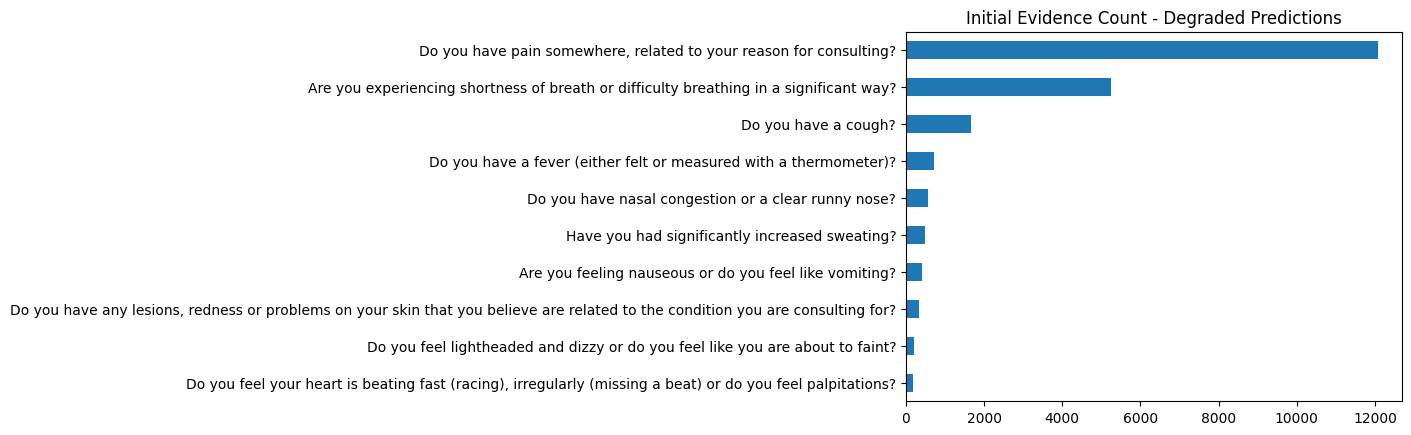

In [23]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded.jpg', bbox_inches='tight')

## Logistic Regression

In [24]:
with open(f"{base_path}\\output\\feature_importance_logreg.json") as f:
  feature_importance_dict = json.load(f)
# feature_importance_dict

In [25]:
valid_df_pred = pd.read_csv(f"{base_path}\\output\\error_analysis\\validation_logreg_df_all_patients.csv", index_col=False).drop(["Unnamed: 0"], axis=1)
valid_df_pred_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\validation_logreg_df_all_patients_questionnaire.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [26]:
valid_df_questionnaire = pd.read_csv(f"{base_path}\\output\\error_analysis_questionnaire\\questionnaire_df_logreg.csv", index_col=False).drop(["Unnamed: 0"], axis=1)

In [27]:
valid_df_pred = valid_df_pred[["PATHOLOGY", "predicted_diagnosis", "is_matched"]]
valid_df_pred

,PATHOLOGY,predicted_diagnosis,is_matched
0,Anemia,['Anemia'],True
1,Panic attack,['Panic attack'],True
2,Influenza,['Influenza'],True
3,Anemia,['Anemia'],True
4,Boerhaave,['Boerhaave'],True
...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True
132444,Acute pulmonary edema,['Acute pulmonary edema'],True
132445,GERD,['GERD'],True
132446,Epiglottitis,['Epiglottitis'],True


In [28]:
valid_df_pred_questionnaire = valid_df_pred_questionnaire[["predicted_diagnosis", "is_matched", "hit_rate"]]
valid_df_pred_questionnaire

,predicted_diagnosis,is_matched,hit_rate
0,['Anemia'],True,1.000000
1,['Panic attack'],True,1.000000
2,['Influenza'],True,0.888889
3,['Stable angina'],False,0.500000
4,['Boerhaave'],True,1.000000
...,...,...,...
132443,['Viral pharyngitis'],True,0.666667
132444,['Acute pulmonary edema'],True,1.000000
132445,['GERD'],True,1.000000
132446,['Epiglottitis'],True,1.000000


In [29]:
match_df = valid_df_pred.join(valid_df_pred_questionnaire.add_suffix("_questionnaire"))
match_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire
0,Anemia,['Anemia'],True,['Anemia'],True,1.000000
1,Panic attack,['Panic attack'],True,['Panic attack'],True,1.000000
2,Influenza,['Influenza'],True,['Influenza'],True,0.888889
3,Anemia,['Anemia'],True,['Stable angina'],False,0.500000
4,Boerhaave,['Boerhaave'],True,['Boerhaave'],True,1.000000
...,...,...,...,...,...,...
132443,Viral pharyngitis,['Viral pharyngitis'],True,['Viral pharyngitis'],True,0.666667
132444,Acute pulmonary edema,['Acute pulmonary edema'],True,['Acute pulmonary edema'],True,1.000000
132445,GERD,['GERD'],True,['GERD'],True,1.000000
132446,Epiglottitis,['Epiglottitis'],True,['Epiglottitis'],True,1.000000


In [30]:
pd.crosstab(index=match_df['is_matched'], columns=match_df['is_matched_questionnaire'])
# 15909 degraded predictions. previously correctly diagnosed but misdiagnosed using the questionnaire
# 219 corrected predictions. prerviously misdiagnosed but correctly diagnosed using the questionnaire

is_matched_questionnaire,False,True
is_matched,,
False,7151,219
True,15909,109169


In [31]:
degraded_df = match_df[(match_df['is_matched']==True) & (match_df['is_matched_questionnaire']==False)]

In [32]:
np.mean(degraded_df["hit_rate_questionnaire"])
# degraded predictions has low questionnaire hit rate, meaning for degraded predictions, relevant symptoms were not asked.

0.5076243338170549

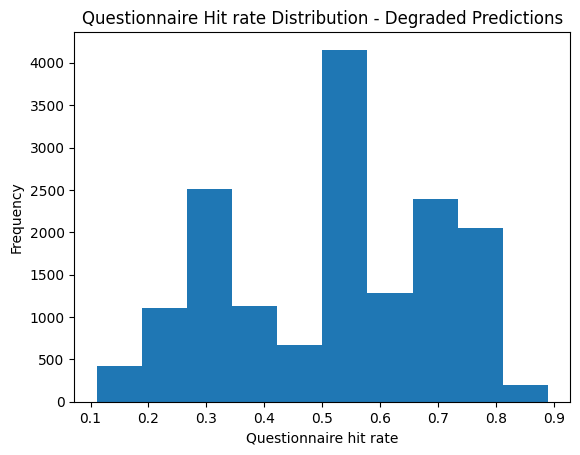

In [33]:
degraded_df["hit_rate_questionnaire"].plot.hist()
plt.title("Questionnaire Hit rate Distribution - Degraded Predictions")
plt.xlabel("Questionnaire hit rate")
plt.savefig(f'{base_path}\\output\\questionnaire\\hit_rate_degraded_logreg.jpg', bbox_inches='tight')

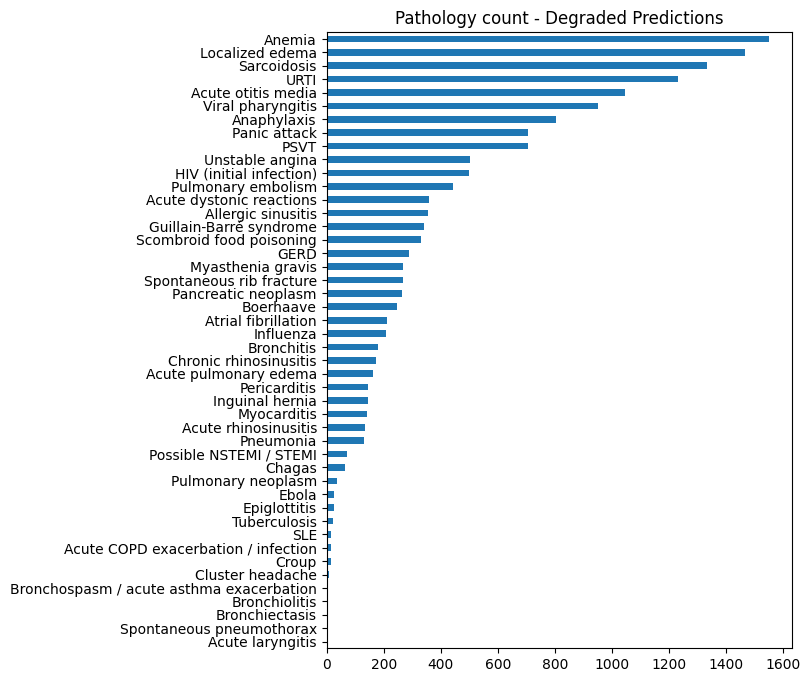

In [34]:
degraded_df["PATHOLOGY"].value_counts().sort_values().plot.barh(figsize=(6, 8))
plt.title("Pathology count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\pathology_freq_degraded_logreg.jpg', bbox_inches='tight')

In [35]:
valid_df_questionnaire

,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
0,"['E_53', 'E_76', 'E_82', 'E_88', 'E_89', 'E_14...","['E_154', 'E_76', 'E_82', 'E_140', 'E_88', 'E_...",E_154,[]
1,"['E_50', 'E_53', 'E_66', 'E_75', 'E_111', 'E_1...","['E_171', 'E_75', 'E_111', 'E_157', 'E_177', '...",E_171,[]
2,"['E_50', 'E_53', 'E_88', 'E_91', 'E_94', 'E_12...","['E_53', 'E_91', 'E_129', 'E_88', 'E_94', 'E_1...",E_53,['E_181']
3,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89']",E_53,"['E_76', 'E_82', 'E_179']"
4,"['E_53', 'E_148', 'E_210']","['E_53', 'E_148', 'E_210']",E_53,[]
...,...,...,...,...
132443,"['E_53', 'E_181', 'E_201']","['E_201', 'E_53']",E_201,['E_181']
132444,"['E_53', 'E_66', 'E_67', 'E_151', 'E_217']","['E_151', 'E_67', 'E_217', 'E_66', 'E_53']",E_151,[]
132445,"['E_53', 'E_173', 'E_201', 'E_215']","['E_173', 'E_215', 'E_201', 'E_53']",E_173,[]
132446,"['E_53', 'E_65', 'E_91', 'E_190', 'E_194']","['E_91', 'E_190', 'E_65', 'E_194', 'E_53']",E_91,[]


In [36]:
degraded_df = degraded_df.join(valid_df_questionnaire)
degraded_df

,PATHOLOGY,predicted_diagnosis,is_matched,predicted_diagnosis_questionnaire,is_matched_questionnaire,hit_rate_questionnaire,binary_evidences_all,binary_evidences,INITIAL_EVIDENCE,missed_evidence
3,Anemia,['Anemia'],True,['Stable angina'],False,0.500000,"['E_53', 'E_66', 'E_76', 'E_82', 'E_89', 'E_179']","['E_53', 'E_66', 'E_89']",E_53,"['E_76', 'E_82', 'E_179']"
7,Acute otitis media,['Acute otitis media'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_114', 'E_201']","['E_201', 'E_53']",E_201,['E_114']
26,Atrial fibrillation,['Atrial fibrillation'],True,['Bronchospasm / acute asthma exacerbation'],False,0.333333,"['E_66', 'E_76', 'E_164']",['E_66'],E_66,"['E_76', 'E_164']"
37,Anemia,['Anemia'],True,['Stable angina'],False,0.400000,"['E_53', 'E_66', 'E_76', 'E_88', 'E_154']","['E_53', 'E_66']",E_53,"['E_76', 'E_88', 'E_154']"
51,Acute dystonic reactions,['Acute dystonic reactions'],True,['Bronchospasm / acute asthma exacerbation'],False,0.200000,"['E_66', 'E_128', 'E_168', 'E_193', 'E_205']",['E_66'],E_66,"['E_193', 'E_205', 'E_128', 'E_168']"
...,...,...,...,...,...,...,...,...,...,...
132395,Acute otitis media,['Acute otitis media'],True,['Acute laryngitis'],False,0.750000,"['E_53', 'E_91', 'E_114', 'E_201']","['E_53', 'E_201', 'E_91']",E_53,['E_114']
132404,GERD,['GERD'],True,['Viral pharyngitis'],False,0.666667,"['E_53', 'E_201', 'E_215']","['E_53', 'E_201']",E_53,['E_215']
132405,PSVT,['PSVT'],True,['Stable angina'],False,0.500000,"['E_53', 'E_66', 'E_76', 'E_155']","['E_66', 'E_53']",E_66,"['E_155', 'E_76']"
132406,Anaphylaxis,['Anaphylaxis'],True,['Pancreatic neoplasm'],False,0.714286,"['E_42', 'E_51', 'E_53', 'E_129', 'E_148', 'E_...","['E_42', 'E_129', 'E_53', 'E_148', 'E_51']",E_42,"['E_151', 'E_194']"


In [37]:
missed_evidences_per_disease = get_misses(degraded_df, feature_importance_dict)

In [38]:
missed_evidences_per_disease["Anemia"] # top 1 degrade

{'top_missed_evidences': {'Do you feel so tired that you are unable to do your usual activities or are you stuck in your bed all day long?': 924,
  'Do you feel lightheaded and dizzy or do you feel like you are about to faint?': 896,
  'Do you feel slightly dizzy or lightheaded?': 893,
  'Have you recently had stools that were black (like coal)?': 855,
  'Is your skin much paler than usual?': 822,
  'Have you noticed light red blood or blood clots in your stool?': 802,
  'Do you have very abundant or very long menstruation periods?': 276},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': {'is_relevant': True,
   'count': 766},
  'Are you experiencing shortness of breath or difficulty breathing in a significant way?': {'is_relevant': True,
   'count': 683},
  'Do you constantly feel fatigued or do you have non-restful sleep?': {'is_relevant': True,
   'count': 102}}}

In [39]:
missed_evidences_per_disease["Localized edema"] # top 2 degrade

{'top_missed_evidences': {'Do you have swelling in one or more areas of your body?': 1466,
  'Have you gained weight recently?': 752},
 'initial_evidences_count': {'Do you have pain somewhere, related to your reason for consulting?': {'is_relevant': True,
   'count': 1466}}}

In [40]:
with open(f"{base_path}\\output\\error_analysis_questionnaire\\missed_evidences_logreg.json", "w") as outfile: 
    json.dump(missed_evidences_per_disease, outfile, indent=True)

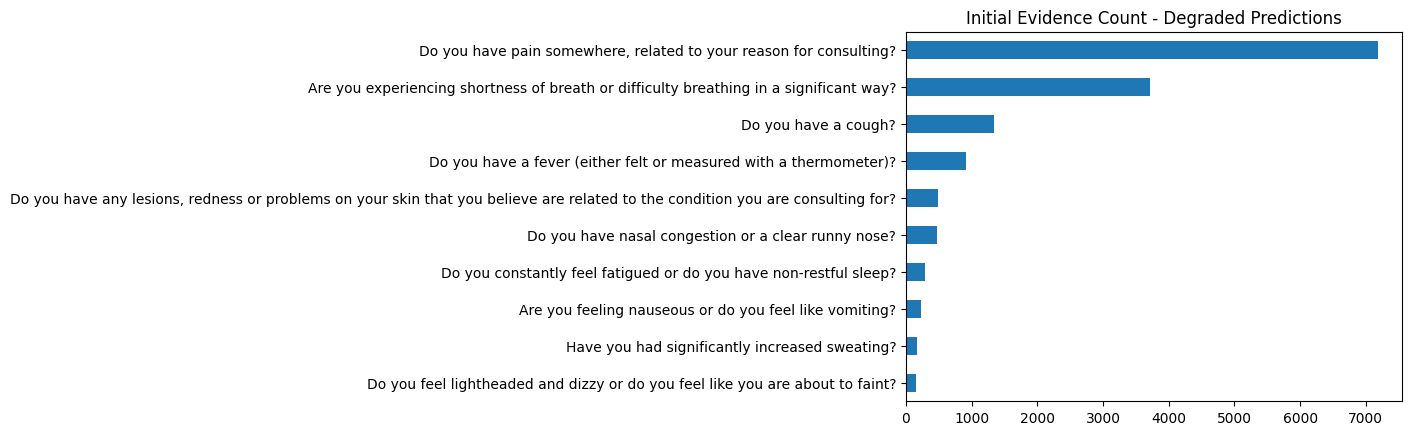

In [41]:
# most common initial evidence for the degrade - Do you have pain somewhere, related to your reason for consulting?, E_53
degraded_df.INITIAL_EVIDENCE.map(evidences_code_to_en).value_counts().sort_values().tail(10).plot.barh()
plt.title("Initial Evidence Count - Degraded Predictions")
plt.savefig(f'{base_path}\\output\\questionnaire\\initial_evidence_freq_degraded_logreg.jpg', bbox_inches='tight')